In [38]:
# importing all the movies' graphs, keeping the non-null ones
import networkx as nx
import os

n_folder = './gexf/'
n_list = [f for f in os.listdir(n_folder) if os.path.isfile(os.path.join(n_folder, f)) and f.endswith('.gexf')]

graphs = []
id_graphs = []
for n in n_list:
    graph = nx.read_gexf(n_folder + n)
    if len(graph) > 1:
        graphs.append(graph)
        id_graphs.append(int(n[:-5]))

In [39]:
# creating a list with the ratings (without the '?')

import pandas as pd

df = pd.read_csv('ratings1.csv')
df2 = df.set_index(df['"mov_galaxy_ID"'])
df2.drop('"mov_galaxy_ID"', inplace=True, axis=1)

ratings = []
id_ratings = []
i=0
for rating in list(df2['"rating"']):
    if rating != '"?"':
        name = list(df2.index)[i][1:4]
        ratings.append(float(rating[1:4]))
        id_ratings.append(int(name))
    i+=1

In [40]:
# Cleaning the data and creating useful lists of tuples

ratings_and_id = []
graphs_and_id = []

for i in range(len(graphs)):
    if id_graphs[i] in id_ratings:
        graphs_and_id.append((id_graphs[i], graphs[i]))


for i in range(len(ratings)):
    if id_ratings[i] in id_graphs:
        ratings_and_id.append((id_ratings[i], ratings[i]))

def take_first(tuple):
    return tuple[0]

graphs_and_id.sort(key=take_first)
ratings_and_id.sort(key=take_first)


graphs = [i[1] for i in graphs_and_id]
ratings = [i[1] for i in ratings_and_id]

In [41]:
# Number of nodes and edges in the graph
nodes = []
edges = []
for graph in graphs:
    nodes.append(graph.number_of_nodes())
    edges.append(graph.number_of_edges())

In [42]:
# Network density

densities = []
for graph in graphs:
    density = nx.density(graph)
    densities.append(density)

In [43]:
# Network diameter

diameters = []
for graph in graphs:
    diameter = nx.diameter(graph)
    diameters.append(diameter)

In [44]:
# Average degrees of the graphs
avg_degrees = []
for graph in graphs:
    degrees = dict(graph.degree())
    avg_degree = sum(degrees.values())/graph.number_of_nodes()
    avg_degrees.append(avg_degree)

In [45]:
# Network highest modularity
import community

modularities = []
for graph in graphs:
    graph1 = graph.to_undirected()
    partition = community.best_partition(graph1)
    modularity = community.modularity(partition, graph1)
    modularities.append(modularity)

In [46]:
# Triadic closure

triadics = []
for graph in graphs:
    triadic = nx.transitivity(graph)
    triadics.append(triadic)

In [47]:
# Max of a Page rank

max_pagerank = []
for graph in graphs:
    pr = nx.pagerank(graph)
    max_pr = max(pr.values())
    max_pagerank.append(max_pr)

In [48]:
list_of_metrics = [('nodes', nodes), ('edges', edges), ('average degree', avg_degrees), ('diameter', diameters), ('density', densities), ('modularity', modularities), ('triadic closure', triadics), ('max PageRank', max_pagerank)]

In [49]:
# calculate the spearman's correlation between each variables chosen and the rating
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr

results = {}

for t in list_of_metrics:
    coef, p = spearmanr(ratings, t[1])
    results[t[0]] = coef

In [50]:
resultats = pd.DataFrame(results, index=[0])
resultats.head()


,nodes,edges,average degree,diameter,density,modularity,triadic closure,max PageRank
0,0.066363,0.019006,-0.07438,0.058171,-0.099995,0.094975,-0.08467,0.029813


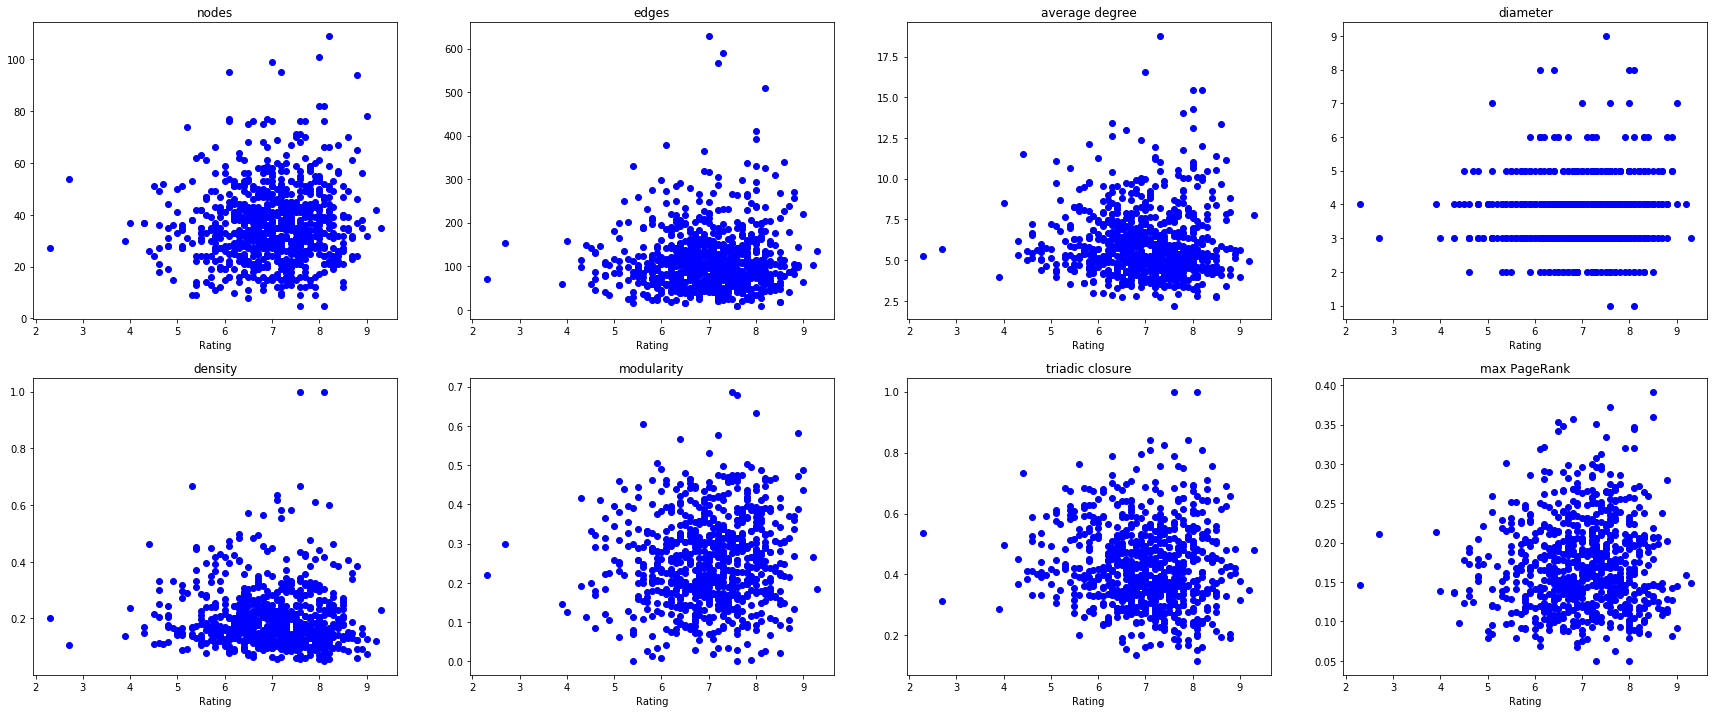

In [51]:
# show
import matplotlib.pyplot as plt


figure, axes = plt.subplots(2, int(len(list_of_metrics)/2), figsize = (30, 12))
for i in range(int(len(list_of_metrics)/2)):
    metric = list_of_metrics[i][1]
    axes[0, i].plot(ratings, metric, 'bo')
    axes[0, i].set_title(list_of_metrics[i][0])
    axes[0, i].set_xlabel("Rating")

for i in range(int(len(list_of_metrics)/2)):
    metric = list_of_metrics[i+4][1]
    axes[1, i].plot(ratings, metric, 'bo')
    axes[1, i].set_title(list_of_metrics[i+4][0])
    axes[1, i].set_xlabel("Rating")

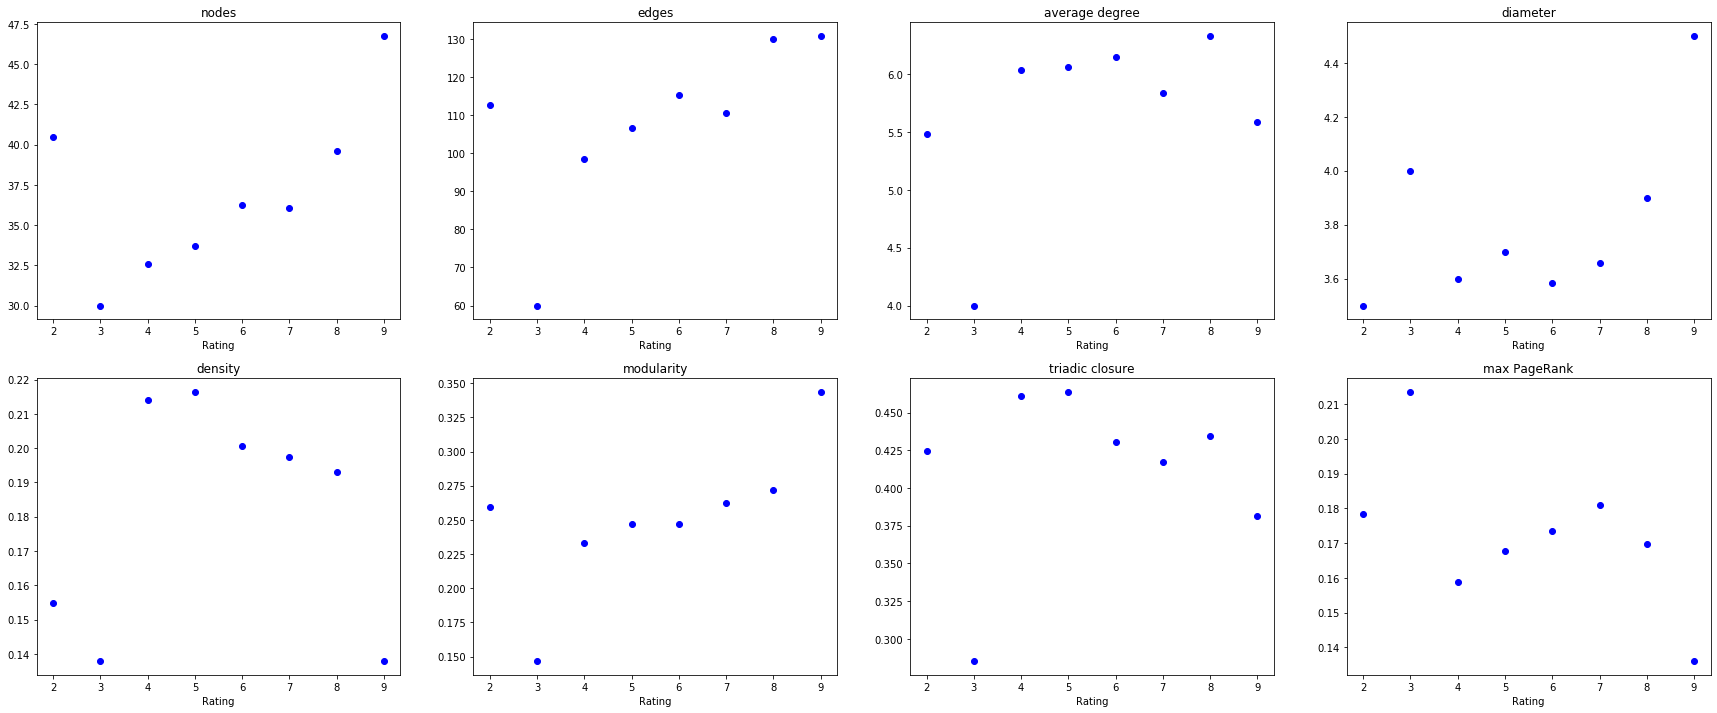

In [52]:
import statistics
ratings_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

figure, axes = plt.subplots(2, 4, figsize = (30, 12))
for t in range(4):
    ratings_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    metric = list_of_metrics[t][1]
    for i in range(len(metric)):
        rate = int(ratings[i])
        ratings_dict[rate].append(metric[i])
    need_drop=[]
    for key in ratings_dict.keys():
        if len(ratings_dict[key]) > 0:
            ratings_dict[key] = statistics.mean(ratings_dict[key])
        else:
            need_drop.append(key)
    for i in need_drop:
        ratings_dict.pop(i)

    axes[0, t].plot([int(k) for k in ratings_dict.keys()], [float(k) for k in ratings_dict.values()], 'bo')
    axes[0, t].set_title(list_of_metrics[t][0])
    axes[0, t].set_xlabel("Rating")

for t in range(4):
    ratings_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    metric = list_of_metrics[t+4][1]
    for i in range(len(metric)):
        rate = int(ratings[i])
        ratings_dict[rate].append(metric[i])
    need_drop=[]
    for key in ratings_dict.keys():
        if len(ratings_dict[key]) > 0:
            ratings_dict[key] = statistics.mean(ratings_dict[key])
        else:
            need_drop.append(key)
    for i in need_drop:
        ratings_dict.pop(i)

    axes[1, t].plot([int(k) for k in ratings_dict.keys()], [float(k) for k in ratings_dict.values()], 'bo')
    axes[1, t].set_title(list_of_metrics[t+4][0])
    axes[1, t].set_xlabel("Rating")


In [53]:
# building new graphs adapted to graph2vec: ordered indexes starting from 0 for the nodes, and undirected graphs
graphs1 = []
for graph in graphs:
    node_dict = {}
    i = 0
    nodes = list(graph.nodes)
    for node in nodes:
        node_dict[node] = i
        i+=1
    graph1 = nx.relabel_nodes(graph, node_dict, copy=True)
    graphs1.append(graph1.to_undirected())



In [54]:
from karateclub.graph_embedding import Graph2Vec

model = Graph2Vec()

model.fit(graphs1)


C:\Users\marcd\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")


In [55]:
graphs_vec = model.get_embedding()

In [56]:
# create  the labels: '0' means than the rating is under the average, '1' means than the rating is above the average.
import statistics

avg_rating = statistics.mean(ratings)
hot_ratings = []
for x in ratings:
    if x > avg_rating:
        hot_ratings.append(1)
    else:
        hot_ratings.append(0)


In [57]:
from sklearn.model_selection import train_test_split
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(graphs_vec, hot_ratings, test_size=0.2, random_state=42)

my_svm = svm.SVC(kernel='sigmoid')

my_svm.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [58]:
from sklearn import metrics

y_pred = my_svm.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test, y_pred))

SVM Accuracy: 0.5496688741721855


In [59]:
from sklearn.linear_model import LogisticRegression

my_logreg = LogisticRegression()
my_logreg.fit(X_train, y_train)

y_pred1 = [round(i) for i in my_logreg.predict(X_test)]
print("LogReg Accuracy:", metrics.accuracy_score(y_test, y_pred1))

LogReg Accuracy: 0.5033112582781457
